# EDA - SPEND ANALYSIS

In [1]:
!pip install pandas seaborn matplotlib pyarrow

## Load the Spark-Exported Data

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

# --- Configuration ---
# Update this path to where you pasted the folder in Windows
# Example: r"C:\Users\YourName\Downloads\financial_spend_analysis"
DATA_PATH = r"C:\Users\Kaju\Desktop\orc file" 

def load_spark_orc_folder(path):
    """
    Reads a directory of ORC files exported by Spark into a single Pandas DataFrame.
    """
    # Find all files ending in .orc inside the folder
    all_files = glob.glob(os.path.join(path, "*.orc"))
    
    if not all_files:
        print(f"No .orc files found in {path}. checking for subdirectories...")
        # sometimes spark creates nested structures, recursive search
        all_files = glob.glob(os.path.join(path, "**/*.orc"), recursive=True)

    print(f"Found {len(all_files)} ORC partitions. Loading...")
    
    # Read each file and combine them
    df_list = [pd.read_orc(filename) for filename in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

# Load the data
df = load_spark_orc_folder(DATA_PATH)

# --- Data Cleaning & Type Conversion ---
# Spark Decimal types often come into Python as 'decimal.Decimal' objects, 
# which Matplotlib cannot plot. We must cast them to float.
numeric_cols = ['total_spend_amount', 'avg_ticket_size', 'fraud_spend_amount', 'max_transaction_val']

for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].astype(float)

# Ensure Date is actually datetime
df['txn_date'] = pd.to_datetime(df['txn_date'])

print("Data Loaded Successfully!")
print(f"Shape: {df.shape}")
df.head()

Found 1 ORC partitions. Loading...
Data Loaded Successfully!
Shape: (10026790, 15)


,txn_date,year,month,age_group,income_tier,user_gender,card_brand,card_type,spend_location_type,mcc,total_spend_amount,transaction_count,avg_ticket_size,fraud_spend_amount,max_transaction_val
0,2008-05-11,2008,5,Millennial,Middle_Income,Female,Mastercard,Debit,Online/Unknown,4121,111.20,5,22.240000,0.0,37.90
1,2007-08-27,2007,8,Millennial,Middle_Income,Female,Mastercard,Debit,Online/Unknown,7801,84.09,1,84.090000,0.0,84.09
2,2009-02-22,2009,2,Millennial,Middle_Income,Female,Mastercard,Debit,Online/Unknown,4121,95.42,6,15.903333,0.0,26.22
3,2007-09-18,2007,9,Millennial,Middle_Income,Female,Mastercard,Debit,Travel_Domestic,7802,106.66,1,106.660000,0.0,106.66
4,2009-03-11,2009,3,Millennial,Middle_Income,Female,Mastercard,Debit,Online/Unknown,4814,139.15,1,139.150000,0.0,139.15


## General Overview & Descriptive Statistics

In [6]:
# Check for missing values and data types
df.info()

# Statistical Summary of the Spending
print("\n--- Descriptive Statistics for Spending ---")
display(df[['total_spend_amount', 'avg_ticket_size', 'transaction_count']].describe())

# Check the date range
print(f"\nDate Range: {df['txn_date'].min()} to {df['txn_date'].max()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10026790 entries, 0 to 10026789
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   txn_date             datetime64[ns]
 1   year                 int32         
 2   month                int32         
 3   age_group            object        
 4   income_tier          object        
 5   user_gender          object        
 6   card_brand           object        
 7   card_type            object        
 8   spend_location_type  object        
 9   mcc                  int32         
 10  total_spend_amount   float64       
 11  transaction_count    int64         
 12  avg_ticket_size      float64       
 13  fraud_spend_amount   float64       
 14  max_transaction_val  float64       
dtypes: datetime64[ns](1), float64(4), int32(3), int64(1), object(6)
memory usage: 1.0+ GB

--- Descriptive Statistics for Spending ---


,total_spend_amount,avg_ticket_size,transaction_count
count,1.002679e+07,1.002679e+07,1.002679e+07
mean,1.061255e+02,5.794890e+01,2.432174e+00
std,1.540579e+02,9.744320e+01,3.430395e+00
min,-9.175800e+02,-5.000000e+02,1.000000e+00
25%,2.150000e+01,1.482500e+01,1.000000e+00
50%,5.651000e+01,3.287000e+01,1.000000e+00
75%,1.307900e+02,6.726500e+01,2.000000e+00
max,1.239050e+04,1.239050e+04,7.100000e+01



Date Range: 1991-01-02 00:00:00 to 2020-02-28 00:00:00


## Temporal Analysis: Spending Over Time

### How does spending fluctuate over time? Are there seasonal spikes?

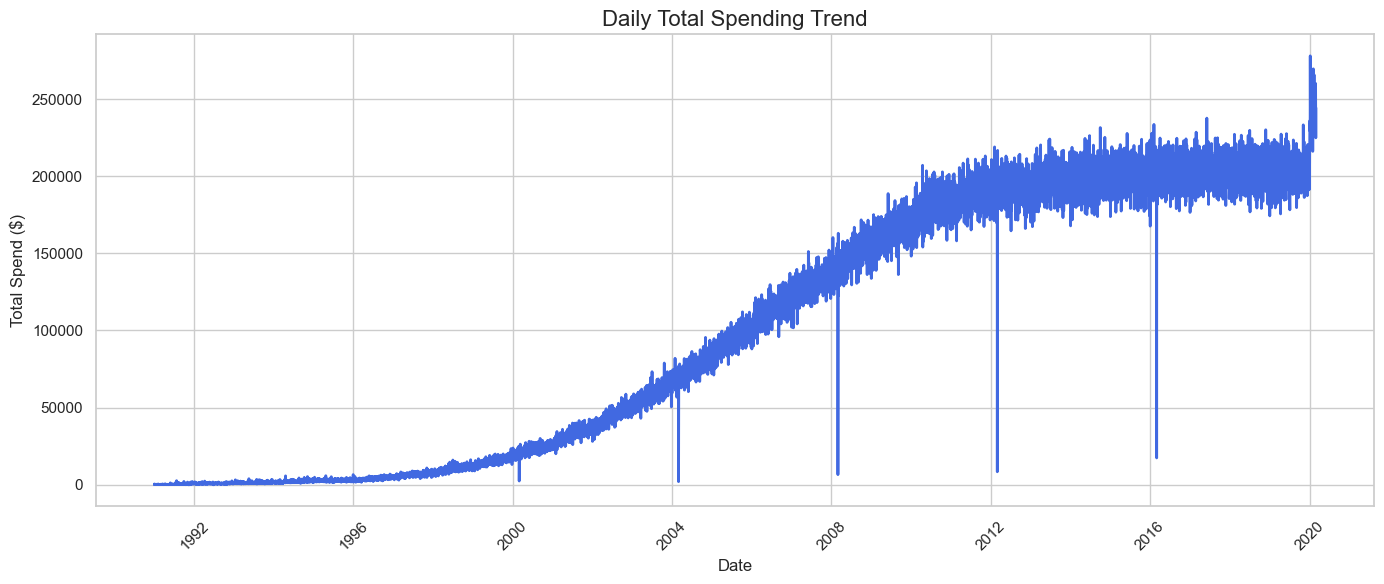

In [7]:
# Set plot style
sns.set_theme(style="whitegrid")

# Aggregate by Date to see the total trend
daily_trend = df.groupby('txn_date')['total_spend_amount'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_trend, x='txn_date', y='total_spend_amount', color='royalblue', linewidth=2)

plt.title('Daily Total Spending Trend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Spend ($)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Demographic Analysis: Who is Spending?

### Which Age Group and Income Tier contributes the most to revenue?

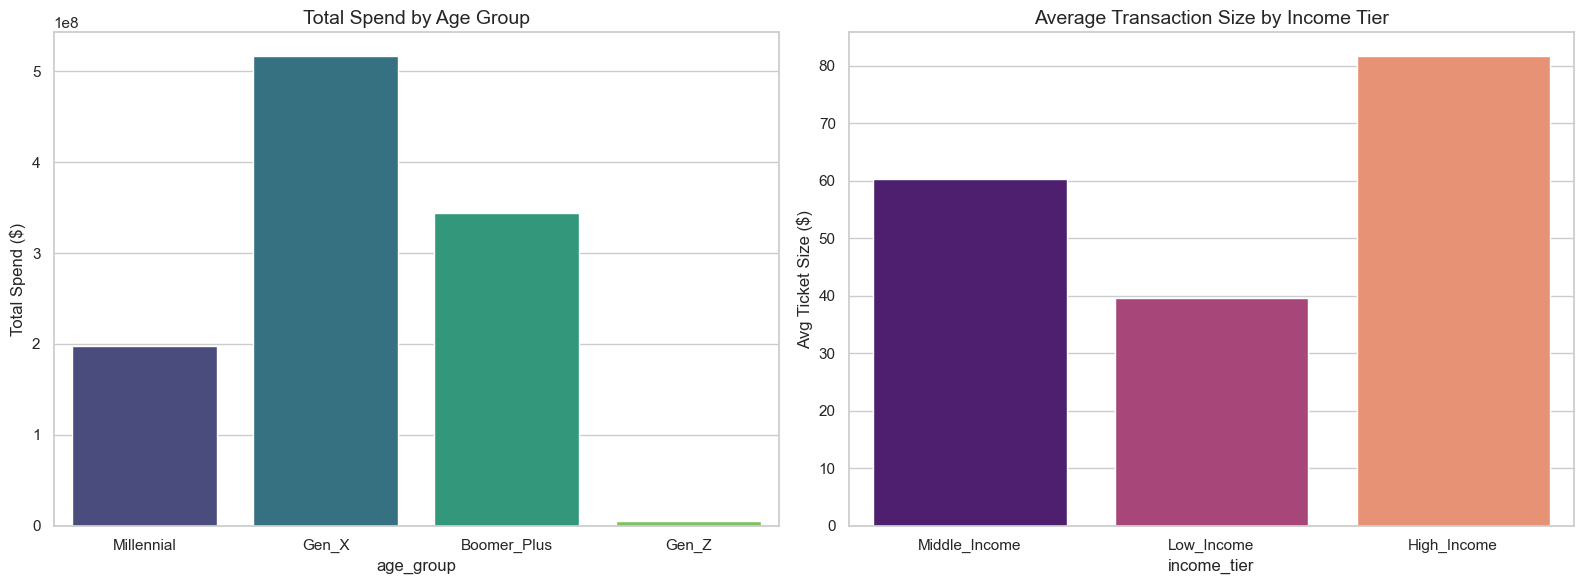

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Spend by Age Group
sns.barplot(
    data=df, 
    x='age_group', 
    y='total_spend_amount', 
    estimator=sum, 
    errorbar=None,       # FIXED: Replaces ci=None
    hue='age_group',     # FIXED: explicit hue assignment
    legend=False,        # FIXED: Hides redundant legend
    palette='viridis',
    ax=axes[0]
)
axes[0].set_title('Total Spend by Age Group', fontsize=14)
axes[0].set_ylabel('Total Spend ($)')

# 2. Spend by Income Tier
sns.barplot(
    data=df, 
    x='income_tier', 
    y='avg_ticket_size', 
    estimator='mean', 
    errorbar=None,       # FIXED: Replaces ci=None
    hue='income_tier',   # FIXED: explicit hue assignment
    legend=False,        # FIXED: Hides redundant legend
    palette='magma',
    ax=axes[1]
)
axes[1].set_title('Average Transaction Size by Income Tier', fontsize=14)
axes[1].set_ylabel('Avg Ticket Size ($)')

plt.tight_layout()
plt.show()

## Behavioral Analysis: Location & Methods

### Are people spending locally or while travelling? Which cards do they prefer?

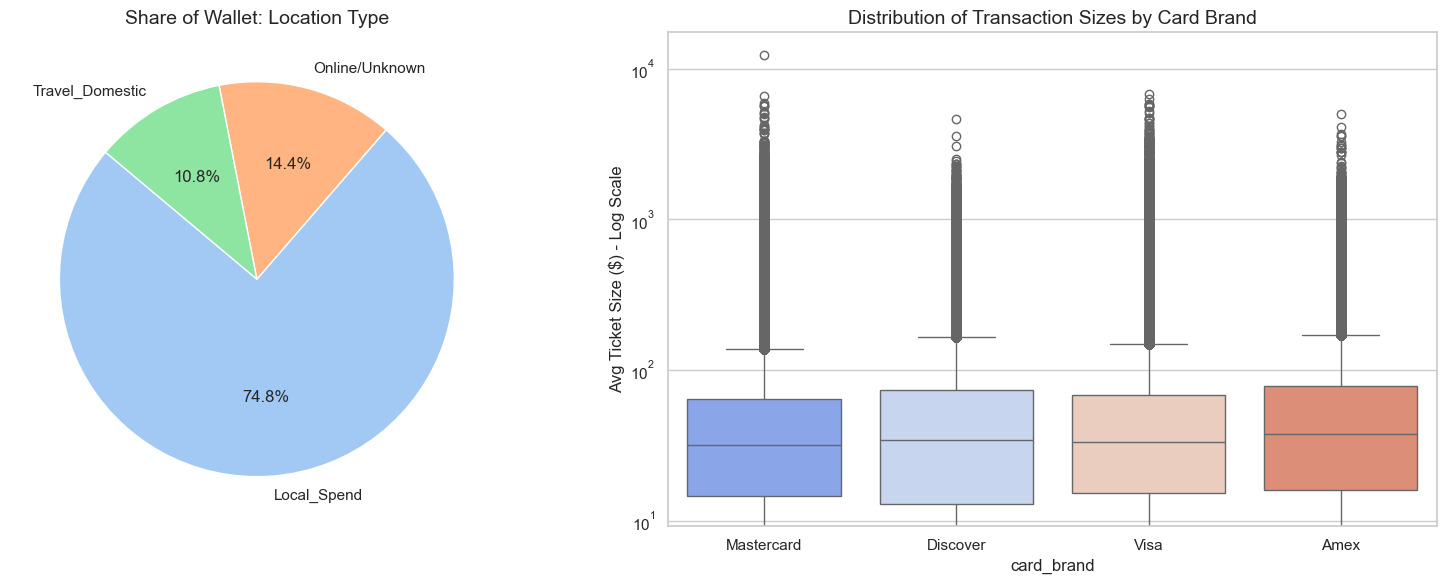

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Location Analysis (Pie Chart) - Standard Matplotlib (No changes needed here)
location_data = df.groupby('spend_location_type')['total_spend_amount'].sum()
axes[0].pie(
    location_data, 
    labels=location_data.index, 
    autopct='%1.1f%%', 
    colors=sns.color_palette('pastel'),
    startangle=140
)
axes[0].set_title('Share of Wallet: Location Type', fontsize=14)

# 2. Card Brand Usage (Box Plot) - UPDATED
sns.boxplot(
    data=df,
    x='card_brand',
    y='avg_ticket_size',
    hue='card_brand',    # FIXED: Explicitly map color to the x-variable
    legend=False,        # FIXED: Hide the redundant legend
    palette='coolwarm',
    ax=axes[1]
)
axes[1].set_title('Distribution of Transaction Sizes by Card Brand', fontsize=14)
axes[1].set_yscale('log') # Log scale because transaction sizes vary wildly
axes[1].set_ylabel('Avg Ticket Size ($) - Log Scale')

plt.tight_layout()
plt.show()

## Advanced Insights: The "Heatmap"

### Correlation between demographics and merchant categories. Who buys what?

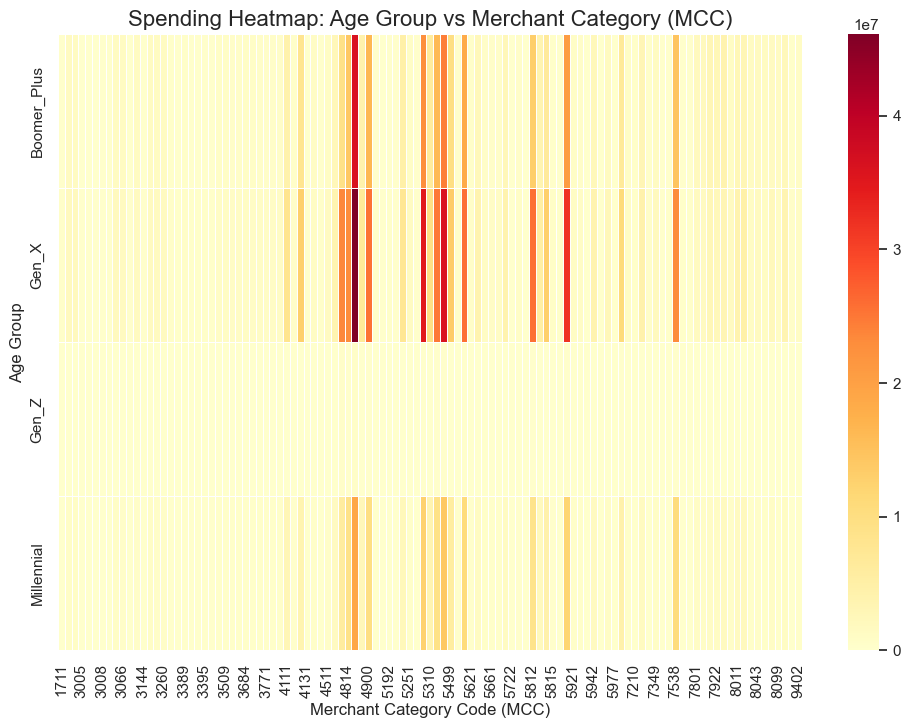

In [17]:
# Pivot data to prepare for heatmap
# We want to see Total Spend for each Age Group vs MCC (Merchant Category)
pivot_table = df.pivot_table(
    index='age_group', 
    columns='mcc', 
    values='total_spend_amount', 
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table, 
    cmap='YlOrRd', 
    annot=False, # Set to True if you want numbers, but might be messy
    linewidths=.5
)

plt.title('Spending Heatmap: Age Group vs Merchant Category (MCC)', fontsize=16)
plt.ylabel('Age Group')
plt.xlabel('Merchant Category Code (MCC)')
plt.show()

###

### Do people spend differently on weekends vs weekdays? Which day is the busiest?

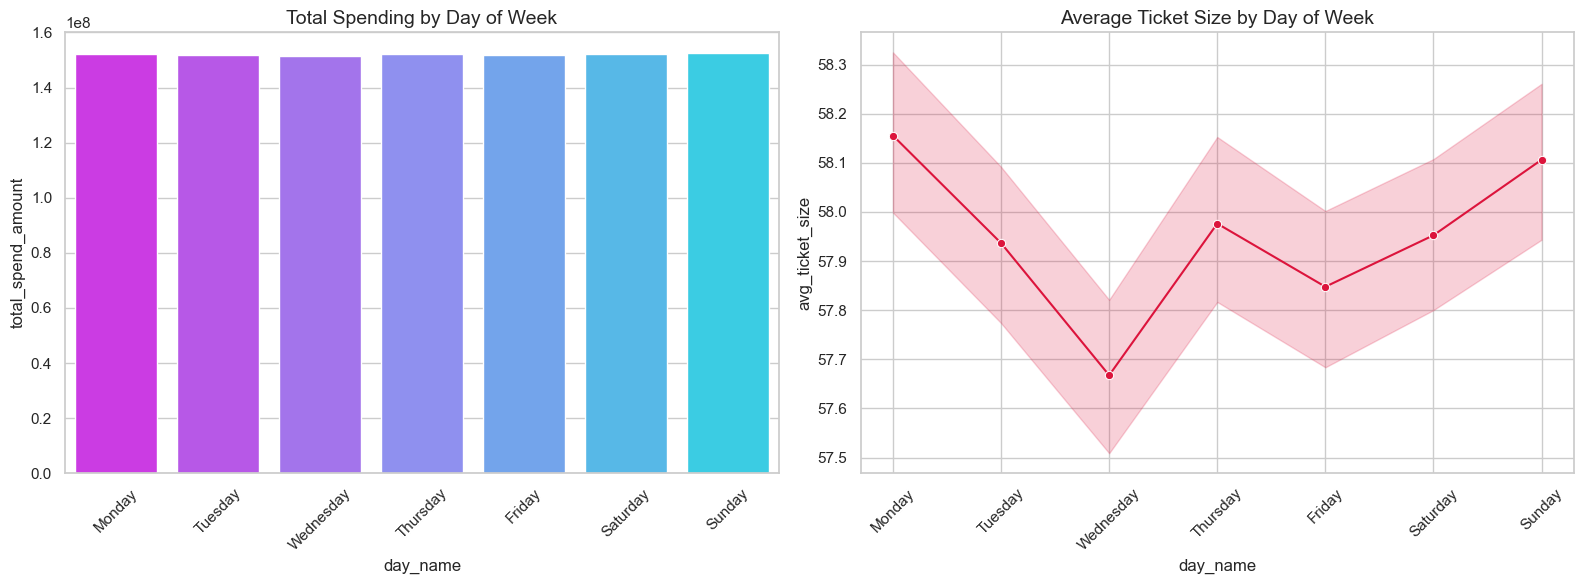

In [21]:
# 8. Seasonality: Weekly Spending Habits

# 1. Convert Date and Create Column
df['txn_date'] = pd.to_datetime(df['txn_date'])
df['day_name'] = df['txn_date'].dt.day_name()

# 2. CRITICAL: Convert 'day_name' to Categorical to ensure Monday-Sunday order
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_name'] = pd.Categorical(df['day_name'], categories=order_days, ordered=True)

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# A. Total Volume by Day of Week
sns.barplot(
    data=df,
    x='day_name',
    y='total_spend_amount',
    estimator=sum,
    errorbar=None,
    hue='day_name',
    palette='cool_r',
    legend=False,
    ax=axes[0]
)
axes[0].set_title('Total Spending by Day of Week', fontsize=14)
# FIX: Use tick_params to rotate labels instead of overwriting them
axes[0].tick_params(axis='x', rotation=45)

# B. Average Ticket Size by Day of Week
sns.lineplot(
    data=df,
    x='day_name',
    y='avg_ticket_size',
    estimator='mean',
    marker="o",
    color='crimson',
    ax=axes[1]
)
axes[1].set_title('Average Ticket Size by Day of Week', fontsize=14)
# FIX: Use tick_params here too
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Customer Value Matrix (Bubble Chart)

### How does Frequency relate to Transaction Size for different segments?
X-Axis: How many times they swiped (Frequency).

Y-Axis: How big the swipe was (Avg Ticket Size).

Size: Total Spend.

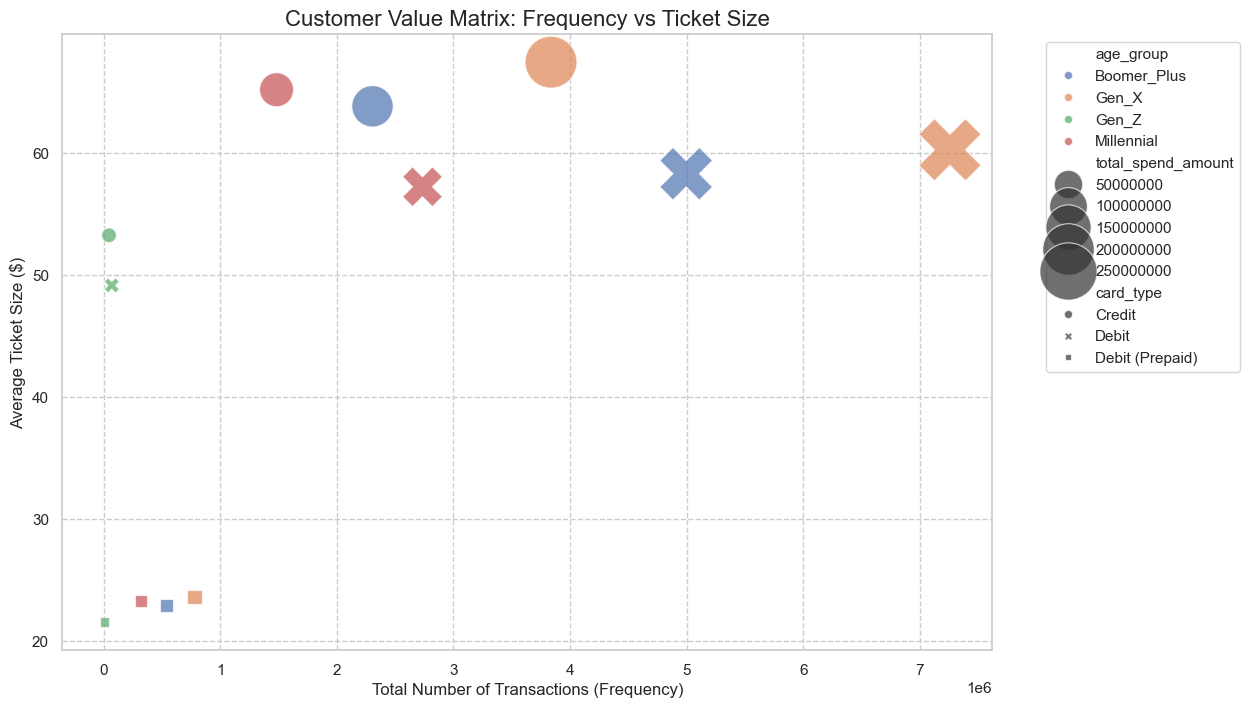

In [22]:
# Group by Age Group and Card Type to see segments
segment_view = df.groupby(['age_group', 'card_type']).agg({
    'transaction_count': 'sum',
    'avg_ticket_size': 'mean',
    'total_spend_amount': 'sum'
}).reset_index()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=segment_view,
    x='transaction_count',
    y='avg_ticket_size',
    size='total_spend_amount',  # Bubble size = Total Money
    hue='age_group',            # Color = Age Group
    style='card_type',          # Shape = Card Type (Debit/Credit)
    sizes=(100, 2000),          # Range of bubble sizes
    alpha=0.7,
    palette='deep'
)

plt.title('Customer Value Matrix: Frequency vs Ticket Size', fontsize=16)
plt.xlabel('Total Number of Transactions (Frequency)', fontsize=12)
plt.ylabel('Average Ticket Size ($)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.grid(True, linestyle='--')
plt.show()

## Fraud Analysis Breakdown

### Which demographics are targeted most by fraud?

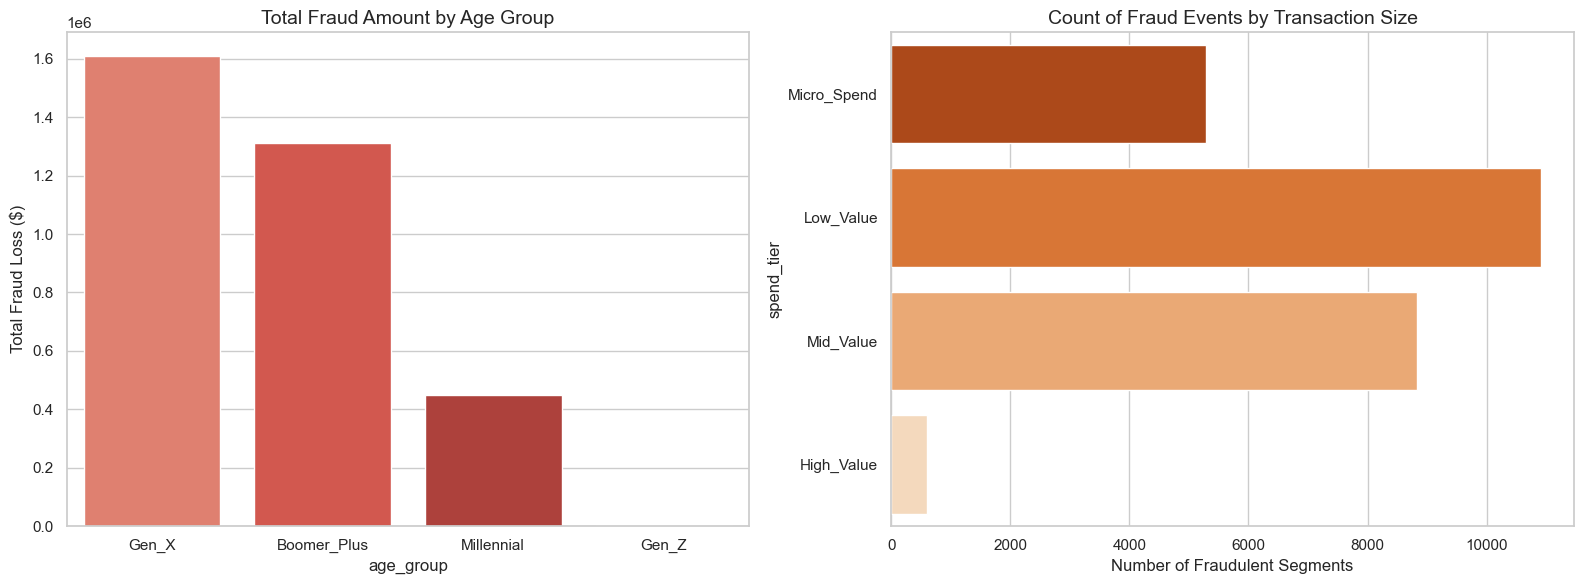

In [24]:
# 10. Fraud Analysis Breakdown

# --- FIX: Re-create 'spend_tier' if it is missing ---
# We define the tiers based on the 'total_spend_amount' or 'avg_ticket_size'
# Since this is aggregated data, we'll base it on the average ticket size of that segment.
if 'spend_tier' not in df.columns:
    df['spend_tier'] = pd.cut(
        df['avg_ticket_size'], 
        bins=[-1, 20, 100, 500, 1000000], 
        labels=['Micro_Spend', 'Low_Value', 'Mid_Value', 'High_Value']
    )
# ----------------------------------------------------

# Filter only rows where fraud happened
fraud_df = df[df['fraud_spend_amount'] > 0].copy() # .copy() avoids SettingWithCopy warnings

if not fraud_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Fraud Volume by Age Group
    sns.barplot(
        data=fraud_df,
        x='age_group',
        y='fraud_spend_amount',
        estimator=sum,
        errorbar=None,
        hue='age_group',
        palette='Reds_d',
        legend=False,
        ax=axes[0]
    )
    axes[0].set_title('Total Fraud Amount by Age Group', fontsize=14)
    axes[0].set_ylabel('Total Fraud Loss ($)')

    # 2. Fraud by Spending Bracket (Tier)
    # Check if 'spend_tier' exists in fraud_df now
    if 'spend_tier' in fraud_df.columns:
        sns.countplot(
            data=fraud_df,
            y='spend_tier', 
            hue='spend_tier',
            palette='Oranges_r',
            legend=False,
            # Ensure the order matches the labels we created above
            order=['Micro_Spend', 'Low_Value', 'Mid_Value', 'High_Value'],
            ax=axes[1]
        )
        axes[1].set_title('Count of Fraud Events by Transaction Size', fontsize=14)
        axes[1].set_xlabel('Number of Fraudulent Segments')
    else:
        axes[1].text(0.5, 0.5, "Spend Tier Data Missing", ha='center')

    plt.tight_layout()
    plt.show()
else:
    print("Good news! No fraud found in this dataset subset.")